### Vorhersage des GameStop Aktienkurses mit einem Rekurrenten neuronalen Netz

In diesem Notebook ist die Vorhersage
des Gamestop-Kurses mit einem rekurrenten Netz
in Python dokumentiert.

#### Rekurrente neuronale Netze

Rekurrente neuronale Netze beschreiben eine Familie von neuronalen Netzen
 für das Verarbeiten sequentieller Daten. Sie sind beispielsweise geeignet
 für die Vorhersage von Textsequenzen oder Zeitreihen. (vgl. Ian Goodfellow et al, Deep Learning, S. 365f)

Rekurrente neuronale Netze haben in der Regel je Zeitschritt ein hidden layer,
welches als Input das hidden layer des vorherigen Zeitschrittes erhält, und als
Output für das nächste hidden layer dient:

![alt text](https://i.stack.imgur.com/BAgBq.jpg "RNN")
(Quelle: https://stats.stackexchange.com/questions/392112/tool-to-draw-neural-network-directed-graphs)
#### Architektur

Die Familie der rekurrenten Netze bietet eine Fülle von Architekturen für die
Zellen(auch genannt Neuronen oder Einheiten). In der Praxis haben sich insbesondere Architekturen mit "gated-cells" bewährt. Wodurch die Zellen mehr Kontrolle
beim Lernen haben, indem sie beispielsweise durch ein Forget-Gate entscheiden, welche Informationen Sie sich merken oder
vergessen wollen.

Wir haben uns für eine Long short-term
memory Architektur entschieden, da sich diese im Allgemeinen und insbesondere im Aktienbereich bewährt hat
und auch in der Theorie eine gute Wahl darstellen sollte (vgl. Ian Goodfellow et al, Deep Learning, S. 397ff)

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Long_Short_Term_Memory.png/400px-Long_Short_Term_Memory.png "LSTM")

(Grober Aufbau einer LSTM-Zelle, Quelle: https://de.wikipedia.org/wiki/Long_short-term_memory)

### Hinweis

Die Zellen müssen alle nacheinander in richtiger Reihenfolge ausgeführt werden, da teilweise auf Daten und Imports vorheriger Zellen zurückgegriffen wird.

#### Vorhersage mit den Kursdaten als einziges Feature

Um den Einfluss der reddit Kommentare und Postings zu erkennen versuchen wir erst den Kurs nur mit der vorherigen
Kursentwicklung vorherzusagen um dieses Ergebnis mit den späteren Ergebnissen zu vergleichen.

Die Daten sehen wie folgt aus:

In [1]:
import pandas as pd
df = pd.read_csv("../input/GME_04Jan_11May.csv")
print("Anzahl der Zeilen und Spalten:", df.shape)
df.head(5)

Anzahl der Zeilen und Spalten: (89, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,19.000000,19.100000,17.15,17.250000,17.250000,10022500
1,2021-01-05,17.350000,18.080000,17.23,17.370001,17.370001,4961500
2,2021-01-06,17.340000,18.980000,17.33,18.360001,18.360001,6056200
3,2021-01-07,18.469999,19.450001,18.02,18.080000,18.080000,6129300
4,2021-01-08,18.180000,18.299999,17.08,17.690001,17.690001,6482000


Es handelt sich hierbei um die Daten vom 04.01.2021 - 12.05.2021, abrufbar unter finance.yahoo.com.
Wie schon im Word-Dokument spezifiziert, werden wir den "Close"-Wert vorhersagen, also den Kurs bei Börsenschluss des
jeweiligen Tages.

Als nächstes teilen wir die Daten in Training- und Test auf. Die ersten 60 Datensätze werden die
Trainingsdaten, die letzten 29 die Testdaten. Das entspricht in etwa einem 2:1 Verhältnis.

In [2]:
train_threshold = 60
train_data = df.iloc[:train_threshold, 4:5].values
test_data = df.iloc[train_threshold:, 4:5].values

Um die Performance zu verbessern normalisieren wir die Daten mithilfe des Min-Max Scalers von Scikit-learn:

In [3]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = normalizer.fit_transform(train_data)

Als nächstes werden die Trainingsdaten vorbereitet. Für ein LSTM benötigen wir einen
drei-dimensionalen Input, bestehend aus Samples x Time Steps x Features.
Ein Sample ist eine Zeitreihe, welche Features zu den jeweiligen Time Steps beinhaltet. Bei uns ist das einzige Feature der Kurswert zum Close.

Die Größe eines Samples, also die Anzahl der enthaltenen Datenpunkte (timesteps) wird mit der variable batch_size definiert.

Zur Erklärung der Inputs und allgemeinen praktischen Umsetzung von LSTM in Keras verweise ich auf dieses
 [Schaubild](https://github.com/MohammadFneish7/Keras_LSTM_Diagram).

Ein Sample ist also eine Zeitreihe von Kurswerten (Anzahl entsprechend der batch_size) am jeweiligen Börsenschluss.

Beim Testen hat sich eine batch_size von 15 bewährt, bei der besten Architektur war jedoch nur
eine batch_size von 5 notwendig, weswegen diese hier benutzt wird.

Unten sieht man beispielhaft anhand von Sample 1 und 2 wie die Inputs aufgebaut sind.

Außerdem werden noch Labels für die Trainingsdaten benötigt, was mit y_train realisiert wird. Das passende label für Sample 1 ist
der letzte Wert von Sample 2, da dieser Wert auf die Zeitreihe von Sample 1 folgt.

In [4]:
batch_size = 5
import numpy as np
X_train = []
y_train = []
for i in range(batch_size, train_threshold):
    X_train.append(train_data_normalized[i-batch_size:i, 0:1])
    y_train.append(train_data_normalized[i,0:1])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("Sample 1:\n", X_train[0])
print("Sample 2:\n", X_train[1])


Sample 1:
 [[0.        ]
 [0.00036335]
 [0.00336099]
 [0.00251317]
 [0.00133229]]
Sample 2:
 [[0.00036335]
 [0.00336099]
 [0.00251317]
 [0.00133229]
 [0.0081451 ]]


Jetzt können wir das Netz bauen.

Ich habe mit einem Skript und einer csv-Datei mit ca. 30 Konfigurationen verschiedene
Architekturen getestet. Jede Architektur wurde 30 mal neu gebaut und der mean-absolute-error(MAE) mit den Testdaten ermittelt. Anschließend wurde
 der Durchschnitt der 30 MAE-Werte ermittelt um für jedes Modell ein
statistisch aussagekräftiges Ergebnis zu haben. Das Skript, die csv, sowie die Ergebnisse sind im Anhang zu finden.

Das Skript heißt mass_training_model.py und die csv-Dateien rnn_model_configs.csv und rnn_configs_with_mae.csv.

Hier ein kurzer Überblick über die besten Ergebnisse:

In [5]:
import pandas as pd
config_with_mae = pd.read_csv("../input/rnn_model_configs_with_MAE_onlyClose")
config_with_mae.sort_values("MAE", axis=0, ascending=True).head(5)

,Unnamed: 0,batch_size,neurons,layers,epochs,MAE
20,20,5,10,3,200,9.381437
22,22,10,10,3,200,9.834293
15,15,20,20,2,200,9.973893
8,8,20,20,1,100,10.111584
16,16,15,20,2,150,10.153545


Man sieht also, dass Architekturen mit drei Layern die besten Ergebnisse hatten. Mit etwas mehr Epochen
konnte man bei diesen Architekturen sogar noch bessere Ergebnisse erzielen. Merkwürdigerweise, ist die beste Architektur
eine mit einer geringen batch_size, obwohl sonst eigentlich eher große batch_sizes zu guten Vorhersageergebnissen geführt haben.

Folgende Architektur bzw. Parameter hatten das beste Ergebnis:

Neuronen: 10

Layer: 3

batch_size: 5

epochs: 300 (in der Test csv nur mit 200 getestet, bei 300 war das Ergebnis aber noch mal etwas besser)

Zur Vermeidung von Overfitting wird ein Dropout-Layer
nach jedem hidden Layer ebenfalls hinzugefügt. Das ist bei kleineren
 Datensätzen sehr hilfreich.

Um die Architektur bzw. Parameter des Netzes zum Testen dynamisch anzupassen, habe ich folgende Funktion gebaut, welche wir auch
direkt ausführen. Das Training kann ein paar Minuten dauern.


In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

neurons = 10
epochs = 300
hidden_layers = 3

def build_model(number_hidden_layers, number_neurons, number_epochs):
    # Sequential = recurrent
    model = Sequential()

    # adding hidden LSTM layers as specified in parameter
    for i in range(1, number_hidden_layers + 1):
        if i == number_hidden_layers and number_hidden_layers == 1:
            model.add(LSTM(units=number_neurons, return_sequences=False, input_shape=
            (X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(0.2))
        elif i == 1:
            model.add(LSTM(units=number_neurons, return_sequences=True, input_shape=
            (X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(0.2))
        elif i == number_hidden_layers:
            model.add(LSTM(units=number_neurons, return_sequences=False))
            model.add(Dropout(0.2))
        else:
            model.add(LSTM(units=number_neurons, return_sequences=True))
            model.add(Dropout(0.2))

    # output layer
    model.add(Dense(units=1))

    # compiling and training
    model.compile(optimizer="adam", loss="mean_absolute_percentage_error")
    model.fit(X_train, y_train, epochs=number_epochs, batch_size=1)

    return model

model = build_model(hidden_layers, neurons, epochs)

Epoch 1/300
55/55 [==============================] - 0s 3ms/step - loss: 91.8586
Epoch 2/300
55/55 [==============================] - 0s 3ms/step - loss: 86.0857
Epoch 3/300
55/55 [==============================] - 0s 3ms/step - loss: 73.2004
Epoch 4/300
55/55 [==============================] - 0s 3ms/step - loss: 71.3486
Epoch 5/300
55/55 [==============================] - 0s 3ms/step - loss: 63.4473
Epoch 6/300
55/55 [==============================] - 0s 3ms/step - loss: 65.1739
Epoch 7/300
55/55 [==============================] - 0s 3ms/step - loss: 72.9652
Epoch 8/300
55/55 [==============================] - 0s 3ms/step - loss: 66.3063
Epoch 9/300
55/55 [==============================] - 0s 3ms/step - loss: 62.8994
Epoch 10/300
55/55 [==============================] - 0s 3ms/step - loss: 57.1378
Epoch 11/300
55/55 [==============================] - 0s 3ms/step - loss: 61.5323
Epoch 12/300
55/55 [==============================] - 0s 3ms/step - loss: 62.8108
Epoch 13/300
55/55 [=====

55/55 [==============================] - 0s 3ms/step - loss: 39.2419
Epoch 101/300
55/55 [==============================] - 0s 3ms/step - loss: 38.5818
Epoch 102/300
55/55 [==============================] - 0s 3ms/step - loss: 35.9857
Epoch 103/300
55/55 [==============================] - 0s 3ms/step - loss: 37.1972
Epoch 104/300
55/55 [==============================] - 0s 3ms/step - loss: 36.3232
Epoch 105/300
55/55 [==============================] - 0s 3ms/step - loss: 35.0950
Epoch 106/300
55/55 [==============================] - 0s 3ms/step - loss: 39.5329
Epoch 107/300
55/55 [==============================] - 0s 3ms/step - loss: 40.4585
Epoch 108/300
55/55 [==============================] - 0s 3ms/step - loss: 31.8751
Epoch 109/300
55/55 [==============================] - 0s 3ms/step - loss: 34.6404
Epoch 110/300
55/55 [==============================] - 0s 3ms/step - loss: 34.5024
Epoch 111/300
55/55 [==============================] - 0s 3ms/step - loss: 42.3436
Epoch 112/300
55/5

55/55 [==============================] - 0s 3ms/step - loss: 34.9491
Epoch 199/300
55/55 [==============================] - 0s 3ms/step - loss: 30.0151
Epoch 200/300
55/55 [==============================] - 0s 3ms/step - loss: 33.4689
Epoch 201/300
55/55 [==============================] - 0s 3ms/step - loss: 25.5655
Epoch 202/300
55/55 [==============================] - 0s 3ms/step - loss: 34.7347
Epoch 203/300
55/55 [==============================] - 0s 3ms/step - loss: 32.0474
Epoch 204/300
55/55 [==============================] - ETA: 0s - loss: 28.68 - 0s 3ms/step - loss: 30.5238
Epoch 205/300
55/55 [==============================] - 0s 3ms/step - loss: 31.0998
Epoch 206/300
55/55 [==============================] - 0s 3ms/step - loss: 38.8296
Epoch 207/300
55/55 [==============================] - 0s 3ms/step - loss: 32.6335
Epoch 208/300
55/55 [==============================] - 0s 3ms/step - loss: 29.0231
Epoch 209/300
55/55 [==============================] - 0s 3ms/step - loss: 35

55/55 [==============================] - 0s 3ms/step - loss: 28.4821
Epoch 296/300
55/55 [==============================] - 0s 3ms/step - loss: 26.7361
Epoch 297/300
55/55 [==============================] - 0s 3ms/step - loss: 27.0373
Epoch 298/300
55/55 [==============================] - 0s 3ms/step - loss: 31.0360
Epoch 299/300
55/55 [==============================] - 0s 3ms/step - loss: 26.1177
Epoch 300/300
55/55 [==============================] - 0s 3ms/step - loss: 32.3538


Das letzte Layer muss immer den Parameter return_sequences=false gesetzt haben, damit wir am Ende auch die Vorhersage für einen Tag bekommen und
nicht wieder eine Sequenz. Bei dem ersten Layer, muss die input shape als
Parameter mitgegeben werden.

Die batch_size, welche als Parameter model.fit übergeben wird ist nicht zu verwechseln mit der batch_size der Samplegröße (Anzahl der timesteps je sample). Die batch_size
bei model.fit gibt an, wie häufig der Gradient in einer Epoche berechnet wird, also nach wie vielen Samples
das Netz korrigiert wird. Es wurde eine batch_size von 1 gewählt, da diese durch die Test und Trainingsmenge teilbar sein muss.
Das führt zwar dazu, dass der Gradient unpräziser wird und mehr hin und her "springt", macht das Training des Netzes aber
auch schneller und effizienter. Es kann somit zwischen einzelnen Trainings zu stärkeren Abweichungen in den metrics kommen, weswegen
die Modelle auch je 30 mal trainiert wurden um dann einen Durchschnitt zu finden. Wenn also das Ergebnis der Metrics weiter unten stark abweicht vom erwarteten,
könnte man das Netz noch mal trainieren und prüfen, ob das Ergebnis besser wird.


Da wir nun ein trainiertes Modell haben, können wir es mit den Testdaten evaluieren. Hierfür müssen wir zuerst die
Testdaten vorbereiten, ähnlich wie wir es mit den Trainingsdaten gemacht haben.

Es wird ein Array aus dem DataFrame gebaut, welches ab dem test_threshold(60) abzüglich der batch_size(5) startet. Also in diesem
Fall 60-5 = 55 -> Das Array besteht also aus den letzten 34 Werten (df[55:]). Die batch_size wird abgezogen,
da die ersten Werte entsprechend der batch_size ja nicht vorhergesagt werden. Das trainierte Modell kennt diese Werte zwar,
da diese die letzten Werte des Trainingsdatensatzes darstellen, weiß aber nicht was darauf folgt. Es hat also keine labels zu
den Testdaten gesehen. Wir sagen also mit einem input von 34 Werten nur 29 (Länge des Testdatensatzes) vorraus.


In [7]:
inputs = df.iloc[:, 4:5]
inputs = inputs[len(inputs) - len(test_data) - batch_size:].values
inputs = inputs.reshape(-1, 1)
inputs = normalizer.transform(inputs)

X_test = []
for i in range(batch_size, len(inputs)):
    X_test.append(inputs[i - batch_size:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Da wir nun die Test-Inputs vorbereitet haben, können wir Vorhersagen machen und diese mit den wahren Werten vergleichen. Vorher müssen wir diese natürlich
in ihre ursprüngliche Form wieder retransformieren.

In [8]:
predicted_stock_price = model.predict(X_test)

predicted_stock_price = normalizer.inverse_transform(predicted_stock_price)

for i in range(len(predicted_stock_price)):
    print("Timestep=%d, Predicted=%f, Actual=%f" % (i+1, predicted_stock_price[i], test_data[i]))

Timestep=1, Predicted=185.697891, Actual=189.820007
Timestep=2, Predicted=178.458679, Actual=191.449997
Timestep=3, Predicted=183.374603, Actual=186.949997
Timestep=4, Predicted=176.682220, Actual=184.500000
Timestep=5, Predicted=176.364487, Actual=177.970001
Timestep=6, Predicted=169.365036, Actual=170.259995
Timestep=7, Predicted=162.862854, Actual=158.360001
Timestep=8, Predicted=150.428925, Actual=141.089996
Timestep=9, Predicted=131.678833, Actual=140.990005
Timestep=10, Predicted=133.294159, Actual=166.529999
Timestep=11, Predicted=164.061676, Actual=156.440002
Timestep=12, Predicted=150.518234, Actual=154.690002
Timestep=13, Predicted=149.597198, Actual=164.369995
Timestep=14, Predicted=160.388016, Actual=158.529999
Timestep=15, Predicted=153.678177, Actual=158.509995
Timestep=16, Predicted=154.329422, Actual=151.169998
Timestep=17, Predicted=144.967346, Actual=151.179993
Timestep=18, Predicted=146.460342, Actual=168.929993
Timestep=19, Predicted=166.476456, Actual=177.770004
Ti

In der Tabellenform sehen die Abweichungen recht passabel aus. Wir stellen
sie nun in einem Plot dar, für einen besseren Überblick:

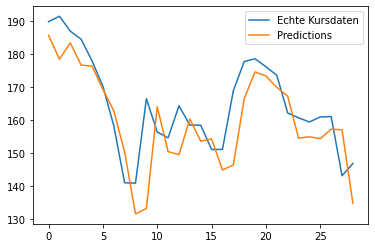

In [9]:
from matplotlib import pyplot

pyplot.plot(test_data, label="Echte Kursdaten")
pyplot.plot(predicted_stock_price, label="Predictions")
pyplot.legend()
pyplot.show()


Anhand des Plots kann man erkennen, dass das Modell anscheinend
dem Trends des Kurses gut, wenn auch etwas zeitverzögert, folgen kann.

Schauen wir uns nun noch die bereits im Word-Dokument definierten Metrics zum Vergleich an. Die metric
mean-directional-accuracy(MDA) zeigt an, wie oft das Modell die Richtung des Kurses am nächsten Tag vorhersagen konnte, also
ob er steigt oder sinkt. Leider hat sci-kit learn hierfür keine Implementation, weswegen
wir die metric noch einmal hier als Funktion einfügen müssen.

In [10]:
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

from sklearn import metrics
# Metrics
print("MAE:", metrics.mean_absolute_error(test_data, predicted_stock_price))
print("MAPE:", metrics.mean_absolute_percentage_error(test_data, predicted_stock_price) * 100)
print("MDA", mda(test_data, predicted_stock_price) * 100)

MAE: 7.8000472925646545
MAPE: 4.799928382398253
MDA 64.28571428571429


Die Ergebnisse sollten etwa in dieser Größenordnung sein, wenn das Netz gut trainiert wurde:

MAE: 6-7

MAPE: ca. 4%

MDA: ca 60%

Sollte das Ergebnis stark abweichen könnte man versuchen das Modell noch mal zu trainieren, da es
aufgrund der geringen batch_size beim Aufrug von model.fit beim Training zu Abweichungen kommen kann.

Eine MDA von ca. 60% ist für die Vorhersage eines Aktienkurses gar nicht so schlecht.
Kurzfristige Entwicklungen in Aktienpreisen sind normalerweise extrem schwer vorherzusagen. Mit 60 % ist man immerhin
10 % besser als bei einem Münzwurf, wenn man die Richtung des Kurses vorhersagen möchte.

MAPE steht für den mean absolute percentage error, welcher einfach den Mean-absolute-error in Verhältnis
zu den Größen im Datensatz setzt, wir haben also eine durchschnittliche Abweichung von ca. 4%.

Schauen wir uns außerdem noch ein paar Kennzahlen des Datensatzes an, um die Metriken
besser evaluieren zu können.

Hierzu habe ich noch eine Methode geschrieben, welche die durchschnittliche Änderung von einem Kurstag zum nächsten berechnet. In diesem Fall für den Testdatensatz, um
es mit den Abweichung unseres Modells von den wahren Werten vergleichen zu können.


In [11]:
def compute_average_change_per_timestep(data):

    """
    Computes average change from one timestep to the other in a set of values
    :param data: one column of values
    :return: average change
    """
    sum = 0
    for i in range(1, len(data)):
        sum += np.sqrt((data[i, 0] - data[i - 1, 0]) ** 2)
    sum = sum / (len(data) - 1)
    return sum

all_close_values = df.iloc[:, 4:5].values

print("standard deviation: ", np.std(all_close_values))
print("mean:", np.mean(all_close_values))

test_close_values = df.iloc[train_threshold - batch_size:, 4:5].values

print("average price change per day test data:", compute_average_change_per_timestep(test_close_values))


standard deviation:  74.52908816735152
mean: 132.42629215730335
average price change per day test data: 8.070908666666668


Die recht hohe Standardabweichung im Verhältnis zum mean zeigt, dass
der Aktienkurs eine hohe Volatilität aufweist, was unseren Modellen eine genaue Prädiktion natürlich erschwert.

Das wir mit unserem MAE unter dem average price change per day liegen, zeigt, dass das Modell einen gewissen Trend
in den Daten erkannt hat und die Kursentwicklung zu einem gewissen Maße vorhersagen kann.


Falls das Ergebnis des besten Netzes nicht nachstellbar gewesen sein sollte, kann man auch noch das Modell mit dem besten Ergebnis einlesen, ohne es vorher
trainieren zu müssen und dieses evaluieren, es sollten folgende Metrics sein:

MAE: 6.516182282260237

MAPE: 4.06202344316333

MDA 60.71428571428571

MAE: 6.516182282260237
MAPE: 4.06202344316333
MDA 60.71428571428571


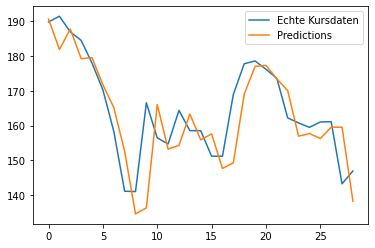

In [12]:
from tensorflow import keras
model = keras.models.load_model("../models/best_close_model")

predicted_stock_price = model.predict(X_test)
predicted_stock_price = normalizer.inverse_transform(predicted_stock_price)

print("MAE:", metrics.mean_absolute_error(test_data, predicted_stock_price))
print("MAPE:", metrics.mean_absolute_percentage_error(test_data, predicted_stock_price) * 100)
print("MDA", mda(test_data, predicted_stock_price) * 100)

pyplot.plot(test_data, label="Echte Kursdaten")
pyplot.plot(predicted_stock_price, label="Predictions")
pyplot.legend()
pyplot.show()

Aus meiner Sicht kann man mit den Metrics durchaus zufrieden sein, wenn man das sonst hohe Zufallsrauschen kurzfristiger Aktienentwicklungen bedenkt.
Außerdem wurde ja bisher nur ein Feature zur Vorhersage genutzt. Schauen wir im nächsten Abschnitt, ob sich die Vorhersage mit einem 2. Feature, der Anzahl
von Postings im wallstreetbets Subreddit, verbessern lässt.


#### Vorhersage mit den Kursdaten und Anzahl der Reddit-Postings als Feature


